In [1]:
# Cell 1: Helpers
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Mapping, Tuple

import matplotlib.pyplot as plt
import numpy as np


def load_final_time_samples(npz_path: Path) -> np.ndarray:
    """Return final-time G samples with shape (n_samples, Nlayer, Nlayer)."""
    with np.load(npz_path) as data:
        G_hist = data["G_hist"]
    return G_hist[:, -1]


def frobenius_norm(matrix: np.ndarray) -> float:
    return float(np.linalg.norm(matrix, ord="fro"))


def occupation_trace(matrix: np.ndarray) -> float:
    return float(np.trace(matrix).real)


def spectral_radius(matrix: np.ndarray) -> float:
    eigvals = np.linalg.eigvals(matrix)
    return float(np.max(np.abs(eigvals)))


def frobenius_standard_error(samples: np.ndarray) -> float:
    """Standard error of Frobenius norm across raw samples."""
    count = samples.shape[0]
    if count <= 1:
        return float("nan")
    sample_norms = np.sqrt(np.sum(np.abs(samples) ** 2, axis=(1, 2)))
    return float(sample_norms.std(ddof=1) / np.sqrt(count))


def mean_estimator(samples: np.ndarray) -> np.ndarray:
    return samples.mean(axis=0)


def median_of_means_estimator(samples: np.ndarray, n_groups: int = None) -> np.ndarray:
    """Elementwise median-of-means estimator."""
    count = samples.shape[0]
    if n_groups is None:
        n_groups = max(1, int(np.sqrt(count)))
    n_groups = max(1, min(n_groups, count))
    groups = [grp for grp in np.array_split(samples, n_groups, axis=0) if grp.size > 0]
    group_means = np.stack([grp.mean(axis=0) for grp in groups], axis=0)
    return np.median(group_means, axis=0)


def analyze_estimator(
    samples: np.ndarray,
    sample_counts: Iterable[int],
    estimator_fn: Callable[[np.ndarray], np.ndarray],
) -> Mapping[str, List[float]]:
    """Apply estimator over increasing sample counts and collect diagnostics."""
    metrics = {
        "frobenius_norm": [],
        "frobenius_se": [],
        "successive_diff": [],
        "occupation_trace": [],
        "spectral_radius": [],
    }
    previous = None

    for count in sample_counts:
        subset = samples[:count]
        estimate = estimator_fn(subset)

        metrics["frobenius_norm"].append(frobenius_norm(estimate))
        metrics["frobenius_se"].append(frobenius_standard_error(subset))
        metrics["occupation_trace"].append(occupation_trace(estimate))
        metrics["spectral_radius"].append(spectral_radius(estimate))

        if previous is None:
            metrics["successive_diff"].append(float("nan"))
        else:
            metrics["successive_diff"].append(frobenius_norm(estimate - previous))
        previous = estimate

    return metrics


def collect_diagnostics(
    final_samples: np.ndarray,
    sample_counts: Iterable[int],
    *,
    include_mom: bool = True,
    mom_groups: int = None,
) -> Dict[str, Mapping[str, List[float]]]:
    """Compute diagnostics for requested estimators."""
    sample_counts = list(sample_counts)
    estimators: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
        "Mean": mean_estimator,
    }
    if include_mom:
        estimators["Median-of-Means"] = lambda data: median_of_means_estimator(
            data, n_groups=mom_groups
        )

    diagnostics: Dict[str, Mapping[str, List[float]]] = {}
    for name, fn in estimators.items():
        diagnostics[name] = analyze_estimator(final_samples, sample_counts, fn)
    return diagnostics


def plot_diagnostics(
    sample_counts: Iterable[int],
    diagnostics: Mapping[str, Mapping[str, List[float]]],
    output_path: Path = None,
):
    """Plot convergence diagnostics and return the figure."""
    sample_counts = list(sample_counts)
    metric_defs: List[Tuple[str, str, str]] = [
        ("frobenius_norm", "Frobenius Norm of Estimate", "||⟨G⟩||₍fro₎"),
        ("frobenius_se", "Std Error of Frobenius Norm", "SE[||G||₍fro₎]"),
        ("successive_diff", "Successive Estimate Difference", "||Δ⟨G⟩||₍fro₎"),
        ("occupation_trace", "Occupation Trace", "Tr(⟨G⟩)"),
        ("spectral_radius", "Spectral Radius", "ρ(⟨G⟩)"),
    ]

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    ax_list = axes.flatten()
    palette = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    for idx, (metric_key, title, ylabel) in enumerate(metric_defs):
        ax = ax_list[idx]
        for color, (label, metrics) in zip(palette, diagnostics.items()):
            values = np.array(metrics[metric_key], dtype=float)
            if metric_key == "successive_diff":
                invalid = ~np.isfinite(values) | (values <= 0)
                values[invalid] = np.nan
                ax.set_yscale("log")
            ax.plot(sample_counts, values, marker="o", label=label, color=color)
        ax.set_title(title)
        ax.set_xlabel("Samples")
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle="--", alpha=0.5)
        if idx == 0:
            ax.legend()

    ax_list[-1].axis("off")
    fig.suptitle("Convergence Diagnostics", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])

    if output_path is not None:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_path, dpi=300)

    return fig


In [ ]:
# Cell 2: Load data and run diagnostics
data_path = Path("cache/G_history_samples/N16x16_C20_S500_nshNone_DW1_init-default_n_a0.5_markov_circuit.npz")
final_samples = load_final_time_samples(data_path)



{'Mean': {'frobenius_norm': [22.171148334649587,
   21.930652420502145,
   21.914328920935024,
   21.93518592679597,
   21.92666284324236,
   21.915718859545596],
  'frobenius_se': [nan,
   0.02046152915415485,
   0.010091983540802983,
   0.0073542963090870335,
   0.005885735020468212,
   0.005032621529042816],
  'successive_diff': [nan,
   4.634333078056298,
   1.008464533763998,
   0.5755496292213762,
   0.3340888220830518,
   0.23543234403433017],
  'occupation_trace': [-4.234482916362747,
   -0.4974419568012429,
   -0.5859142487963744,
   -0.6882542378771959,
   -0.6319937342373532,
   -0.38211182873734906],
  'spectral_radius': [1.0000000000000022,
   1.0000000000000036,
   1.0000000000000033,
   1.0000000000000053,
   1.000000000000004,
   1.0000000000000024]}}

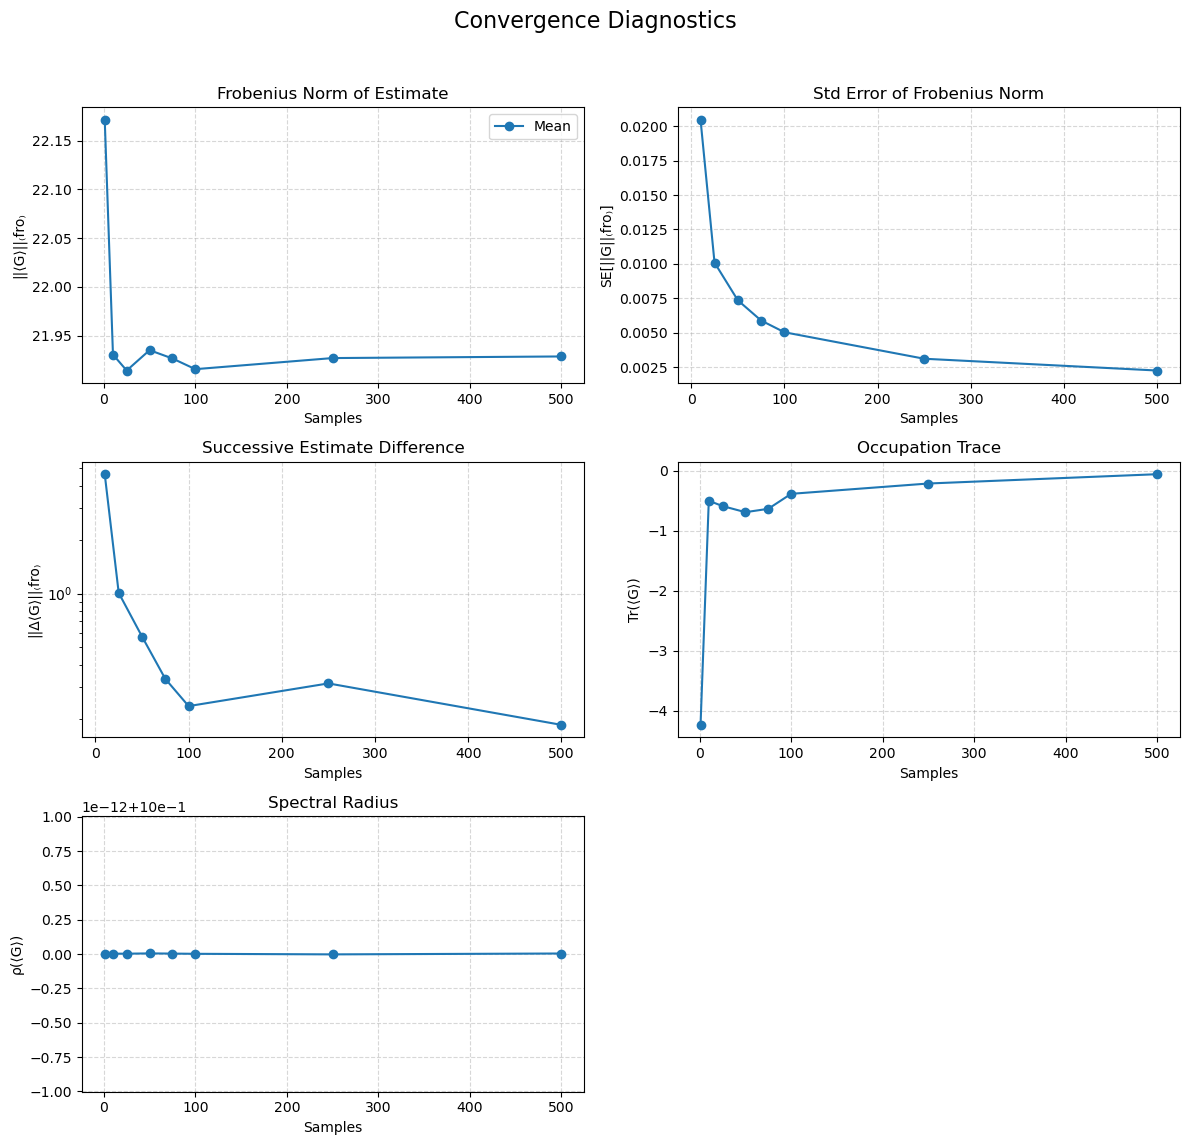

In [4]:
sample_counts = [1, 10, 25, 50, 75, 100, 250, 500]

diagnostics = collect_diagnostics(
    final_samples,
    sample_counts,
    include_mom=False,   # set False to drop the MoM curves
    mom_groups=5,       # optional override; None defaults to floor(sqrt(S))
)
diagnostics
# Cell 3: Plot (and optionally save)
fig = plot_diagnostics(
    sample_counts,
    diagnostics,
    output_path=None)
plt.show()
